# Exporation of Data clusters

In [1]:
import os
import sys
sys.path.append('../pyWholeBrain')
import numpy as np
import colorsys
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import scipy
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage

from skimage.measure import label, regionprops
from scipy.ndimage.filters import gaussian_filter, convolve
from skimage.morphology import disk, watershed
from skimage.morphology import erosion, dilation, opening, closing

from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.filters import maximum_filter
from sklearn.model_selection import train_test_split

from hdf5manager import hdf5manager as h5
import wholeBrain as wb

Error importing slackNotify.py
	 ERROR :  No module named 'slacker'


## Load the data

In [4]:
file_dir = '/Users/shreyamantripragada/Documents/'

file = '170721_07_c1_gridOpticFlow_metrics.csv'

data_big = pd.DataFrame.from_csv(file_dir + file)
print(data_big.head())

   angs.stdev   angs.mean  mov.mean  mov.std  mov.mode  mov.range  \
0  106.240669  147.795502     0.384    1.869         2     22.682   
1         NaN         NaN     0.000    0.000     16678      0.000   
2         NaN         NaN     0.000    0.000     16678      0.000   
3         NaN         NaN     0.000    0.000     16678      0.000   
4         NaN         NaN     0.000    0.000     16678      0.000   

   mov.eventrest  mov.maxeventval  mov.surfarea  mov.totalmag  ...  \
0              1            0.384          1831      5692.449  ...   
1              0            0.000             0         0.000  ...   
2              0            0.000             0         0.000  ...   
3              0            0.000             0         0.000  ...   
4              0            0.000             0         0.000  ...   

   mov.timefromevent  mov.numlocmax  brain.data  brain.eventrest  \
0                  0            364      -0.038                0   
1                  1        

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """


## Scale

In [3]:
# data_big -= data_big.min() # is this scaling getting rid of features due to outliers?
# data_big /= data_big.max()

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_scaled = scaler.fit_transform(data_big)
x_scaled.shape
columns = data_big.columns.tolist()
for i, col in enumerate(columns):
    data_big[col] = x_scaled[:,i]
    

## approximate classification

In [6]:
# Classification
indices_big = np.zeros(len(data_big))
indices_big[2445 : 3388] = 1
indices_big[5166 : 5569] = 1
indices_big[8617 : 9298] = 1
indices_big[11751 : 12024] = 1
indices_big[15367 : 15889] = 1
indices_big[17619 : 17964] = 1
data_big['classification'] = indices_big

## Select the variable that are best
### Use SMOTE

In [7]:
from imblearn.over_sampling import SMOTE

y = data_big.loc[:,'classification'].values

# y = np.squeeze(pd.DataFrame(np.ndarray.astype(y, int), columns=['signal']))
X = data_big.loc[:, data_big.columns != 'classification'].fillna(value=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

#augment your data
os = SMOTE(random_state=42)

columns = X_train.columns
os_data_X, os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data = os_data_y, columns =['classification'])

print('Length of data augmentation:', len(os_data_X))
print('Number of addition singal points: {0} \t\tProportion: {1}'.format(len(os_data_y[os_data_y['classification'] == 1]), len(os_data_y[os_data_y['classification'] == 1])/len(os_data_X)))
print('Number of addition non-singal points: {0} \tProportion: {1}'.format(len(os_data_y[os_data_y['classification'] == 0]), len(os_data_y[os_data_y['classification'] == 0])/len(os_data_X)))


ModuleNotFoundError: No module named 'imblearn'

### Recursive Feature Elimination

In [7]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

logreg = LogisticRegression(solver='lbfgs')

rfe = RFE(logreg, 20) #increase paramater for numnber of iterations?
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
data_final_vars = os_data_X.columns.tolist()

print('Support\tRanking\tVariable')
for i, var in enumerate(data_final_vars):
    print(rfe.support_[i], '\t',rfe.ranking_[i],'\t', var)

new_vars = X.columns.values[rfe.ranking_ == 1].tolist()
# new_vars.append('class')
new_vars.append('classification')

print(new_vars)



/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Support	Ranking	Variable
True 	 1 	 angs.stdev
False 	 8 	 angs.mean
True 	 1 	 mov.mean
True 	 1 	 mov.std
False 	 7 	 mov.mode
True 	 1 	 mov.range
True 	 1 	 mov.eventrest
False 	 3 	 mov.maxeventval
True 	 1 	 mov.surfarea
False 	 5 	 mov.totalmag
False 	 10 	 mov.firstder
False 	 12 	 mov.secder
True 	 1 	 mov.stdx
False 	 11 	 mov.stdy
False 	 9 	 mov.diffxystd
False 	 2 	 mov.diffmaxevents
False 	 13 	 mov.percent
True 	 1 	 mov.percenterror
True 	 1 	 mov.timetoevent
True 	 1 	 mov.timefromevent
True 	 1 	 mov.numlocmax
True 	 1 	 mov.mag_per_event
True 	 1 	 mov.duration
True 	 1 	 mov.btwnrest
True 	 1 	 brain.data
True 	 1 	 brain.eventrest
True 	 1 	 brain.rangemaxmin
True 	 1 	 brain.firstder
True 	 1 	 brain.secondder
True 	 1 	 diff.brainmov
False 	 6 	 diff.brainmovfirstder
False 	 4 	 diff.brainmovsecder
['angs.stdev', 'mov.mean', 'mov.std', 'mov.range', 'mov.eventrest', 'mov.surfarea', 'mov.stdx', 'mov.percenterror', 'mov.timetoevent', 'mov.timefromevent', 'mov.numloc

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nob

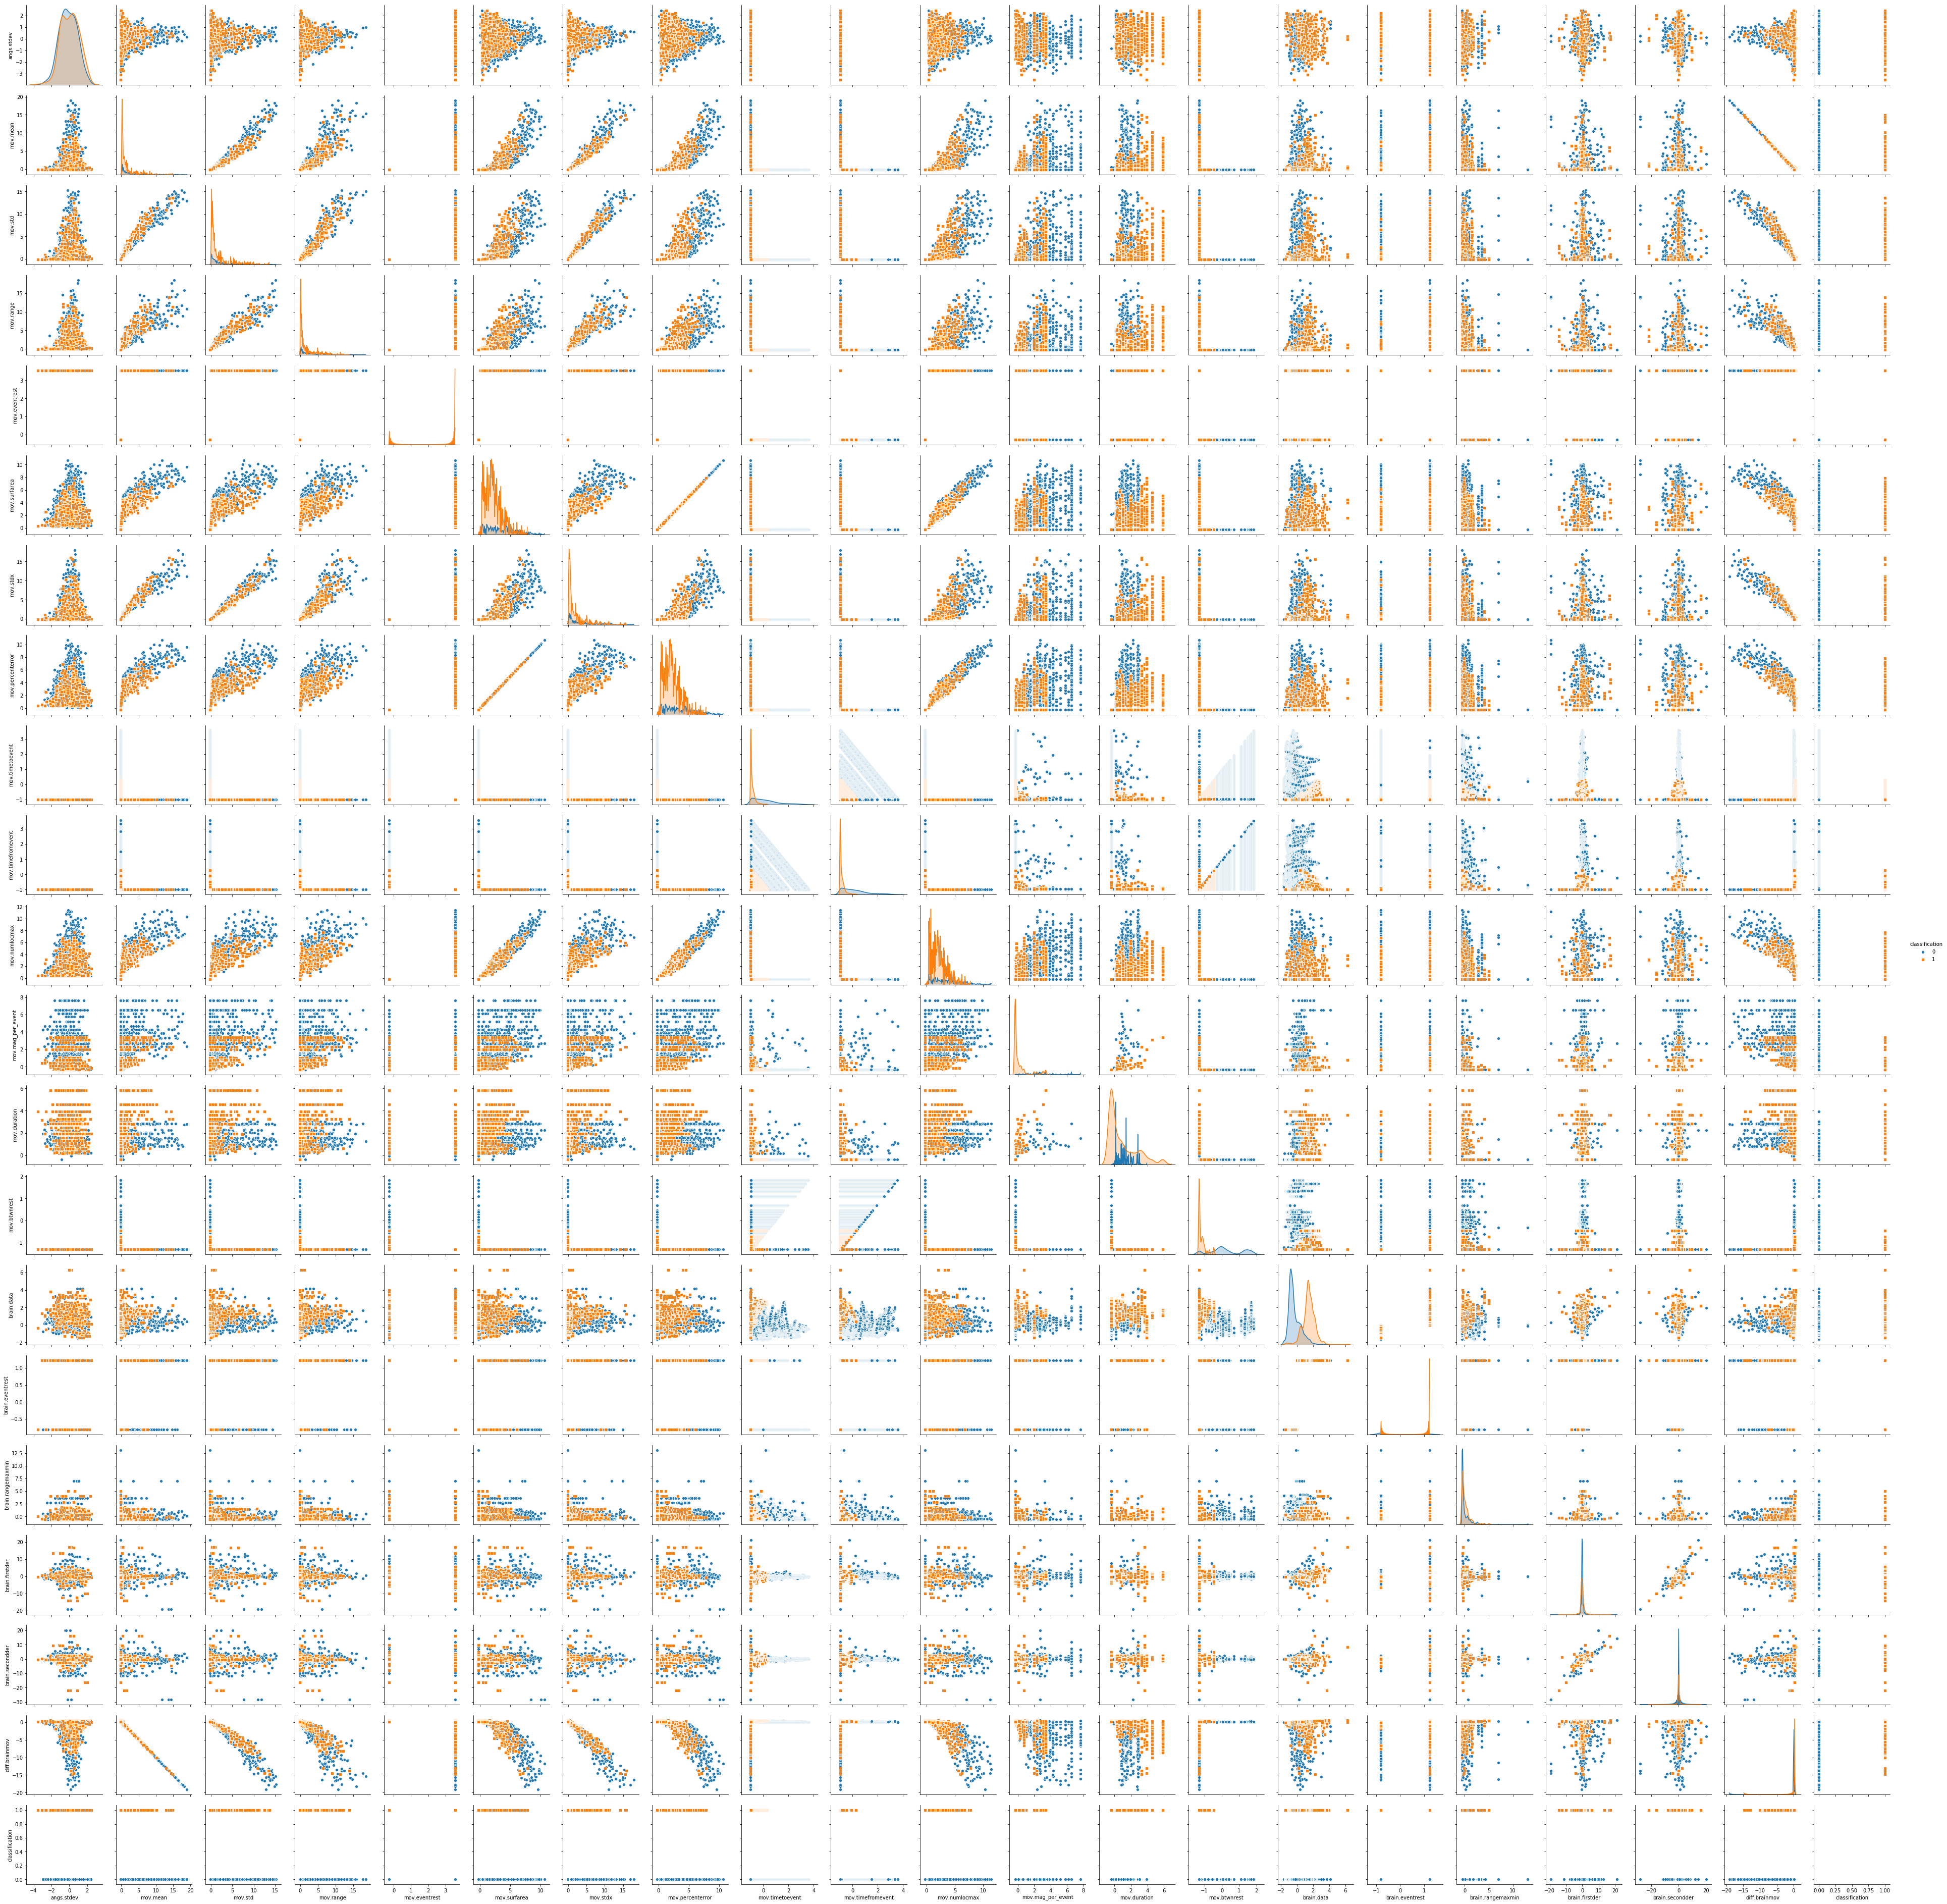

In [28]:
data3 = data_big[new_vars]

# Both temporal and spatial metrics visualize  
sns.pairplot(data3, 
             diag_kind="kde", 
             markers=["o", "s"], 
             hue_order = [0, 1], hue='classification')

plt.savefig(file_dir + 'state_pairplot.png')
plt.show()

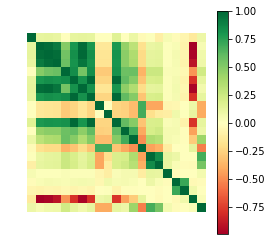

mov.mean mov.std
mov.mean mov.range
mov.mean mov.stdx
mov.mean diff.brainmov
mov.std mov.mean
mov.std mov.range
mov.std mov.stdx
mov.std diff.brainmov
mov.range mov.mean
mov.range mov.std
mov.range mov.stdx
mov.range diff.brainmov
mov.surfarea mov.percenterror
mov.surfarea mov.numlocmax
mov.stdx mov.mean
mov.stdx mov.std
mov.stdx mov.range
mov.stdx diff.brainmov
mov.percenterror mov.surfarea
mov.percenterror mov.numlocmax
mov.numlocmax mov.surfarea
mov.numlocmax mov.percenterror
diff.brainmov mov.mean
diff.brainmov mov.std
diff.brainmov mov.range
diff.brainmov mov.stdx


In [9]:
data3 = data_big[new_vars]


plt.matshow(data3.corr().values, cmap = 'RdYlGn')
plt.colorbar()
plt.axis('off')
plt.show()

x, y = np.where(np.abs(data3.corr().values) > 0.9)
for i, var in enumerate(x):
    if var != y[i]:
        print(new_vars[var], new_vars[y[i]])

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


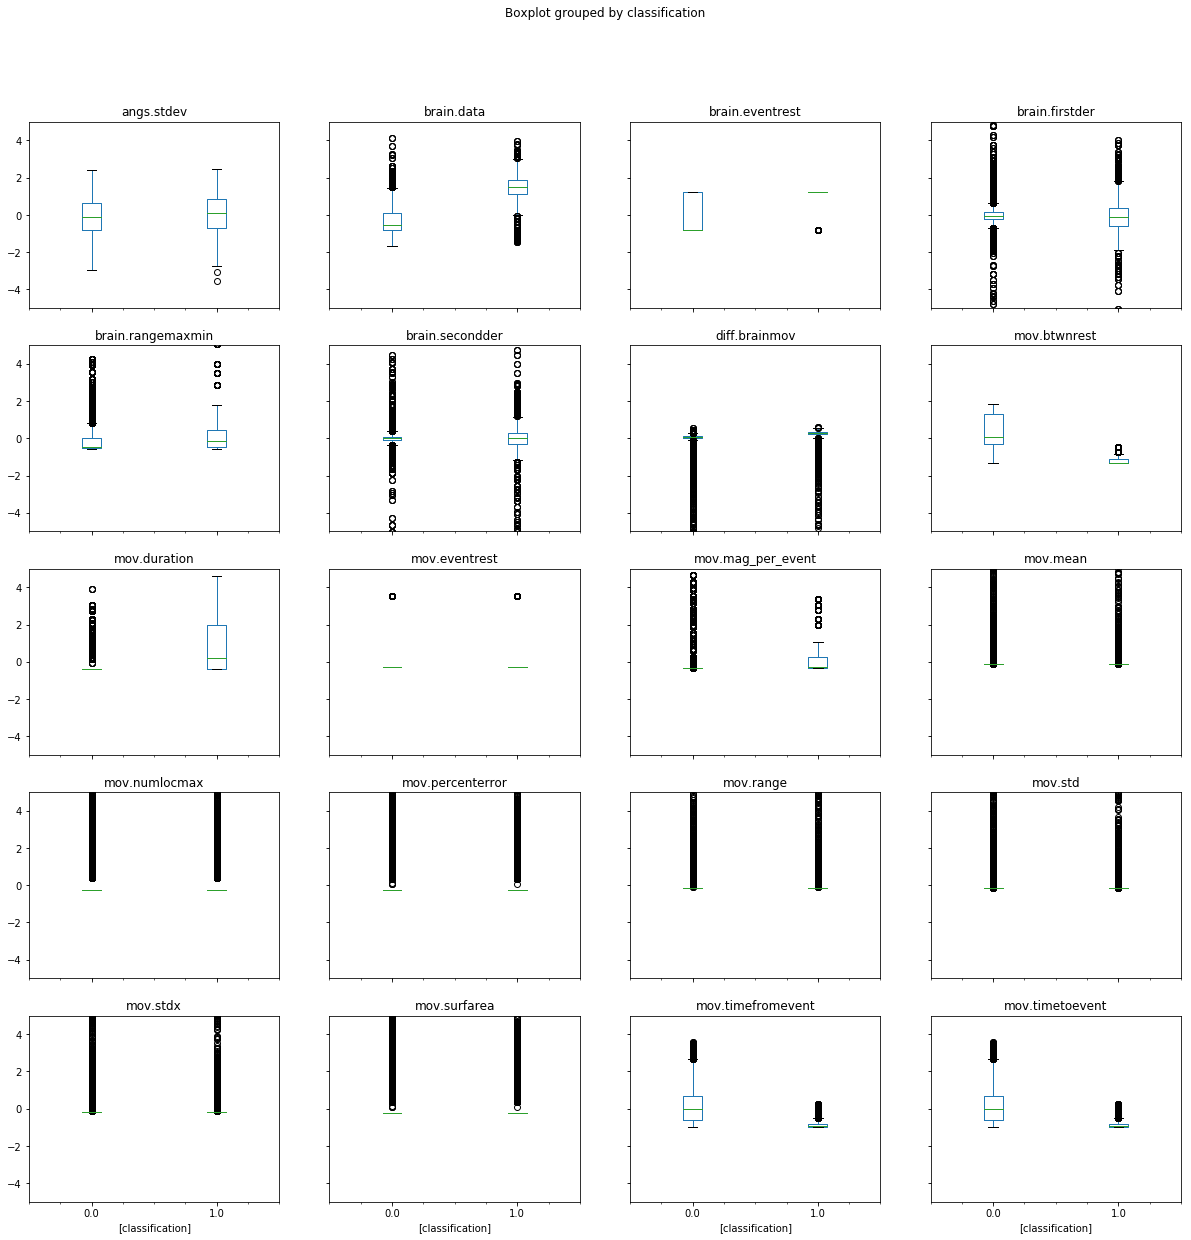

In [10]:
data3.boxplot(by='classification', figsize = (20,20), grid = 'off')
plt.ylim([-5,5])
plt.show()

In [27]:
new_new_vars = ['angs.stdev', 
 #'mov.mean', 'mov.surfarea', #'mov.numlocmax', 'mov.std', 'mov.range', 'mov.eventrest', 'mov.stdx', 'mov.percenterror', 
 'mov.duration', 'mov.btwnrest', #'mov.timetoevent', 'mov.timefromevent', 'mov.mag_per_event', 
 'brain.data', #'diff.brainmov', 'brain.eventrest', 'brain.rangemaxmin', 'brain.firstder', 'brain.secondder',  
 'classification'
    ]

In [28]:
data4 = data_big[new_new_vars].fillna(value=0)

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


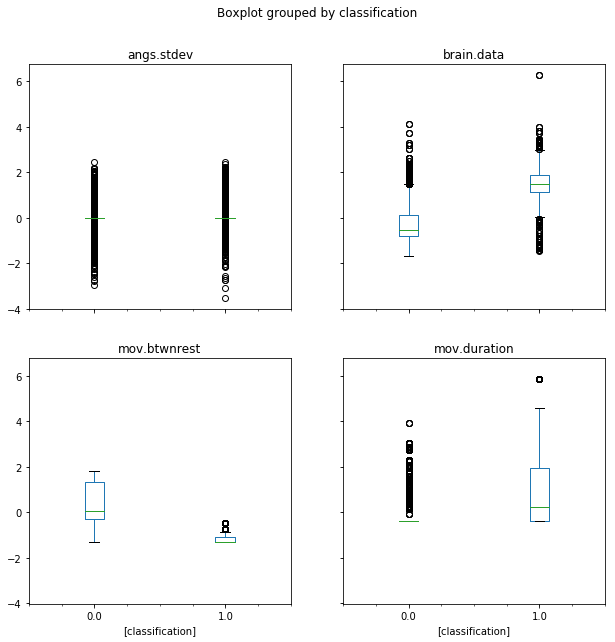

In [29]:
data4.boxplot(by='classification', figsize = (10,10), grid = 'off')
plt.show()

# Visualize data

In [30]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, 
            perplexity=5, # between 5 and 50 only 
#             learning_rate = 300,
            random_state=42)
X_reduced_tsne = tsne.fit_transform(data_big[new_new_vars].fillna(value=0).values)


In [31]:
# from sklearn.manifold import MDS

# mds = MDS(n_components=2, random_state=42)
# X_reduced_mds = mds.fit_transform(data_big[new_new_vars].fillna(value=0).values)

In [32]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(data_big[new_new_vars].fillna(value=0).values)

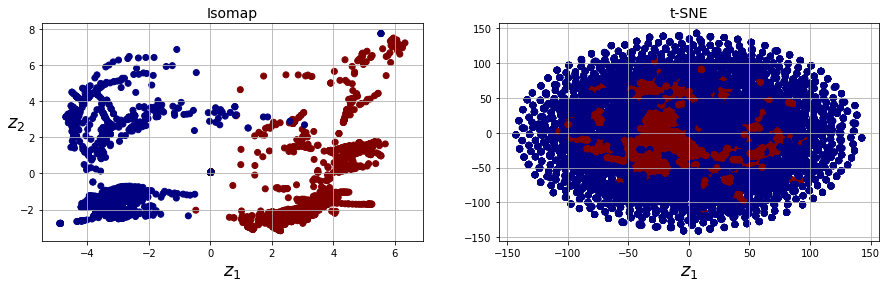

In [33]:
titles = ["Isomap", "t-SNE"]

plt.figure(figsize=(15,4))

for subplot, title, X_reduced in zip((121, 122), titles,
                                     (X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=data_big['classification'], cmap=plt.cm.jet)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 121:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

# save_fig("other_dim_reduction_plot")
plt.show()